# __Statistical Modelling__

__Objective:__

 Investigating the relationship between increase of urban area and flood extent.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Data Loading and Preprocessing

In [ ]:
url = "https://raw.githubusercontent.com/MIT-Emerging-Talent/ET6-CDSP-group-01-repo/refs/heads/main/1_datasets/clean_data/merged_data_new2.csv"
df_merged_data = pd.read_csv(url)

In [3]:
print(f"Data shape: {df_merged_data.shape}")
print(f"Cities: {df_merged_data['City'].unique()}")
# rename flood extend column to avoid errors
df_merged_data = df_merged_data.rename(
    columns={"Total Flood Extent (km^2)": "Total_Flood_Extent_km2"}
)
df_merged_data.head()

Data shape: (42, 5)
Cities: ['Addis Ababa' 'Kampala']


,City,Year,Rainfall_mm,Total_Flood_Extent_km2,Urban_Area
0,Addis Ababa,2005,1174.917609,1966.254434,83318084.00
1,Addis Ababa,2006,1322.667343,1417.851332,84320897.75
2,Addis Ababa,2007,1261.028727,1553.415543,86141302.86
3,Addis Ababa,2008,1121.388045,1403.095318,89936037.78
4,Addis Ababa,2009,1158.312130,1529.397062,92625150.10


In [4]:
# City scalling
def scale_city_data(group):
    scaler = StandardScaler()
    group[["Urban_scaled", "Rainfall_scaled"]] = scaler.fit_transform(
        group[["Urban_Area", "Rainfall_mm"]]
    )
    return group


df_merged_data = df_merged_data.groupby("City").apply(scale_city_data)

# Regression Modelling

In [5]:
# Standardize continuous variables
scaler = StandardScaler()
df_merged_data[["Urban_Area_z", "Rainfall_z"]] = scaler.fit_transform(
    df_merged_data[["Urban_Area", "Rainfall_mm"]]
)

In [6]:
model = smf.ols(
    "Total_Flood_Extent_km2 ~ Urban_Area * C(City) + Rainfall_mm", data=df_merged_data
).fit()

print(model.summary())

# Extract city-specific effects
addis_urban_effect = model.params["Urban_Area"]
kampala_urban_effect = (
    model.params["Urban_Area"] + model.params["Urban_Area:C(City)[T.Kampala]"]
)


print(f"\nAddis urban effect: {addis_urban_effect:.1f} km²")
print(f"Kampala urban effect: {kampala_urban_effect:.1f} km²")

                              OLS Regression Results                              
Dep. Variable:     Total_Flood_Extent_km2   R-squared:                       0.848
Model:                                OLS   Adj. R-squared:                  0.832
Method:                     Least Squares   F-statistic:                     51.73
Date:                    Sun, 27 Jul 2025   Prob (F-statistic):           1.18e-14
Time:                            22:16:52   Log-Likelihood:                -288.51
No. Observations:                      42   AIC:                             587.0
Df Residuals:                          37   BIC:                             595.7
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

- Urbanization reduces flood extent in both cities (negative coefficients)
- Counterintuitive result: Urbanization associates with reduced flooding

                              OLS Regression Results                              
Dep. Variable:     Total_Flood_Extent_km2   R-squared:                       0.873
Model:                                OLS   Adj. R-squared:                  0.859
Method:                     Least Squares   F-statistic:                     63.41
Date:                    Sun, 27 Jul 2025   Prob (F-statistic):           4.72e-16
Time:                            22:16:52   Log-Likelihood:                -284.83
No. Observations:                      42   AIC:                             579.7
Df Residuals:                          37   BIC:                             588.3
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

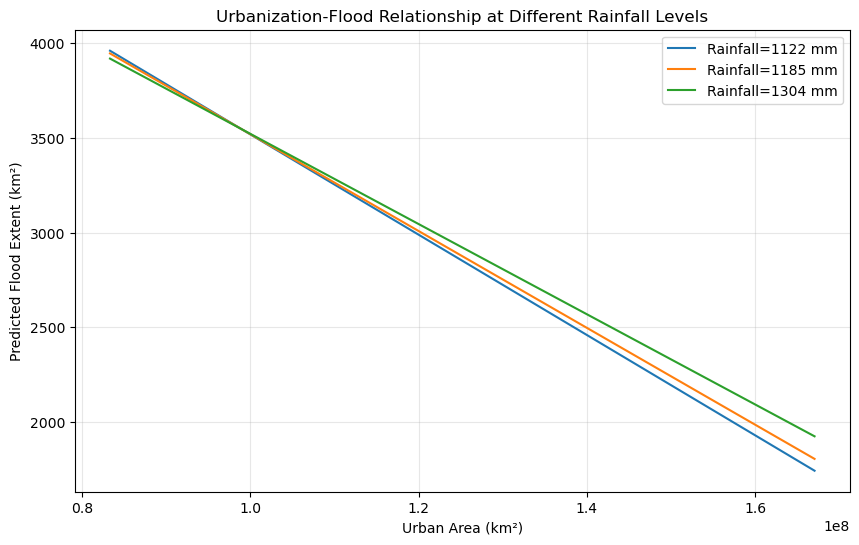

In [7]:
# Model with urban-rainfall interaction
interaction_model = smf.ols(
    "Total_Flood_Extent_km2 ~ Urban_Area * Rainfall_mm + C(City)", data=df_merged_data
).fit()

print(interaction_model.summary())

# Extract amplification effect
amplification_coef = interaction_model.params["Urban_Area:Rainfall_mm"]
p_value = interaction_model.pvalues["Urban_Area:Rainfall_mm"]

print(f"\nRainfall amplification effect: {amplification_coef:.2f} (p={p_value:.3f})")


# Visualize interaction
def plot_interaction(model, data):
    plt.figure(figsize=(10, 6))

    # Calculate predictions
    urban_range = np.linspace(data["Urban_Area"].min(), data["Urban_Area"].max(), 50)
    rain_levels = [data["Rainfall_mm"].quantile(q) for q in [0.25, 0.5, 0.75]]

    for rain in rain_levels:
        preds = []
        for urban in urban_range:
            pred = model.predict(
                pd.DataFrame(
                    {
                        "Urban_Area": [urban],
                        "Rainfall_mm": [rain],
                        "City": ["Kampala"],  # Reference city
                    }
                )
            )
            preds.append(pred[0])

        plt.plot(urban_range, preds, label=f"Rainfall={rain:.0f} mm")

    plt.xlabel("Urban Area (km²)")
    plt.ylabel("Predicted Flood Extent (km²)")
    plt.title("Urbanization-Flood Relationship at Different Rainfall Levels")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_interaction(interaction_model, df_merged_data)